Objectifs :

- Appliquer la méthode de sous-échantillonnage "downsampling" pour traiter les données déséquilibrées de la variable cible "grav",
- Réduire la dimensionnalité des données en utilisant l'analyse en Composantes Principales (PCA) avec deux composantes,
- Trouver la configuration de PCA qui maximise les performances du modèle pour les différentes métriques considérées,
- Entraîner un modèle d'arbre de décision en utilisant la technique de Random Forest,
- Mesurer le temps d'entraînement du modèle et calculer les métriques.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_csv('fusion3.csv', low_memory=False)

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['Unnamed: 0','num_acc','an_nais','an_naiss','age_acc_an','num_veh','senc','occutc','permis','secuDeux','date'], axis=1)
df['place'] = df['place'].astype('object')
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291739 entries, 0 to 2291796
Data columns (total 35 columns):
 #   Column              Dtype  
---  ------              -----  
 0   place               object 
 1   catu                object 
 2   grav                object 
 3   sexe                object 
 4   trajet              object 
 5   locp                object 
 6   actp                object 
 7   etatp               object 
 8   secuUn              object 
 9   tranches_ages       object 
 10  catr                object 
 11  circ                object 
 12  nbv                 float64
 13  vosp                object 
 14  prof                object 
 15  plan                object 
 16  surf                object 
 17  infra               object 
 18  situ                object 
 19  obs                 object 
 20  obsm                object 
 21  choc                object 
 22  manv                object 
 23  catv_Label          object 
 24  lum                 obje

<h1>Encodage des variables</h1>

Les variables sont encodées une à une afin de pallier à un déficit de mémoire sur certaines machines.

In [ ]:
df = pd.get_dummies(df, columns=['catu'])

In [ ]:
le = LabelEncoder()
df['sexe'] = le.fit_transform(df['sexe'])

In [ ]:
df = pd.get_dummies(df, columns = ['trajet'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['locp'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['actp'])

In [ ]:
df = pd.get_dummies(df, columns = ['etatp'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['secuUn'])

In [ ]:
df = pd.get_dummies(df, columns = ['tranches_ages'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['catr'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['circ'])

In [ ]:
# Binary Encoding
df['vosp'] = df['vosp'].apply(lambda x: 0 if x == 'Sans objet(0)' else 1)

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['prof'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['plan'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['surf'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['infra'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['situ'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['obs'])

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['obsm'])

In [ ]:
# Regrouper la catégorie "Non renseigné" avec "Aucun"
df['choc'] = df['choc'].replace('Non renseigné', 'Aucun')

# Effectuer le one-hot encoding
df = pd.get_dummies(df, columns=['choc'])

In [ ]:
frequency_encoding = df['manv'].value_counts(normalize=True)
df['manv'] = df['manv'].map(frequency_encoding)

In [ ]:
frequency_encoding = df['catv_Label'].value_counts(normalize=True)
df['catv_Label'] = df['catv_Label'].map(frequency_encoding)

In [ ]:
frequency_encoding = df['dep'].value_counts(normalize=True)
df['dep'] = df['dep'].map(frequency_encoding)

In [ ]:
frequency_encoding = df['com'].value_counts(normalize=True)
df['com'] = df['com'].map(frequency_encoding)

In [ ]:
df = pd.get_dummies(df, columns = ['lum'])

In [ ]:
df['agg'] = df['agg'].replace({'En agglomération': 1, 'Hors agglomération': 0})

In [ ]:
df = pd.get_dummies(df, columns = ['int'])

In [ ]:
df = pd.get_dummies(df, columns = ['atm'])

In [ ]:
df = pd.get_dummies(df, columns = ['col'])

In [ ]:
df = pd.get_dummies(df, columns = ['jour_de_la_semaine'])

In [ ]:
df.shape

(2291739, 195)

In [ ]:
df.columns

Index(['place', 'grav', 'sexe', 'nbv', 'vosp', 'manv', 'catv_Label', 'agg',
       'com', 'dep',
       ...
       'col_Sans collision',
       'col_Trois véhicules et plus - collisions multiples',
       'col_Trois véhicules et plus – en chaîne',
       'jour_de_la_semaine_Dimanche', 'jour_de_la_semaine_Jeudi',
       'jour_de_la_semaine_Lundi', 'jour_de_la_semaine_Mardi',
       'jour_de_la_semaine_Mercredi', 'jour_de_la_semaine_Samedi',
       'jour_de_la_semaine_Vendredi'],
      dtype='object', length=195)

<h1>Rééquilibrage de classe</h1>

In [ ]:
# Affichage des différentes valeurs de la colonne "grav"
unique_grav_values = df['grav'].unique()
print("Valeurs uniques de la colonne grav :", unique_grav_values)

Valeurs uniques de la colonne grav : ['Blessé léger' 'Blessé hospitalisé' 'Indemne' 'Tué']


In [ ]:
# Vérification des  proportions de chaque niveau de gravité
df['grav'].value_counts()

Indemne               937743
Blessé léger          825286
Blessé hospitalisé    467533
Tué                    61177
Name: grav, dtype: int64

In [ ]:
# Remplacement des valeurs dans la colonne 'grav'
df['grav'] = df['grav'].replace({'Blessé léger': 'non grave', 'Indemne': 'non grave', 'Blessé hospitalisé': 'grave', 'Tué': 'grave'})

# Affichage des nouvelles proportions
df['grav'].value_counts()

# Calcul des proportions en pourcentage
proportions = (value_counts / len(df)) * 100
proportions = proportions.round(2)

# Affichage des proportions en pourcentage
print(proportions)

In [ ]:
from sklearn.utils import resample

# Comptage des occurrences de chaque classe de la variable cible "grav"
class_counts = df['grav'].value_counts()

# Identification de la classe majoritaire
majority_class = class_counts.idxmax()

# Calcul du nombre d'occurrences souhaité pour les autres classes de la variable cible "grav"
target_count = class_counts.min()  # Utilisation de la taille de la classe minoritaire

# Sous-échantillonnage pour chaque classe
undersampled_data = []
for cls in class_counts.index:
    cls_data = df[df['grav'] == cls]
    undersampled_cls_data = resample(cls_data, replace=False, n_samples=target_count, random_state=42)
    undersampled_data.append(undersampled_cls_data)

# Concaténation des données sous-échantillonnées
undersampled_data = pd.concat(undersampled_data)

# Mélange des données pour garantir l'ordre aléatoire
undersampled_data = undersampled_data.sample(frac=1, random_state=42)

In [ ]:
# Vérification des nouvelles proportions de chaque niveau de gravité
undersampled_data['grav'].value_counts()

Blessé hospitalisé    61177
Blessé léger          61177
Tué                   61177
Indemne               61177
Name: grav, dtype: int64

In [ ]:
df = undersampled_data

In [ ]:
df.head(10)

,place,grav,sexe,nbv,vosp,manv,catv_Label,agg,com,dep,...,col_Sans collision,col_Trois véhicules et plus - collisions multiples,col_Trois véhicules et plus – en chaîne,jour_de_la_semaine_Dimanche,jour_de_la_semaine_Jeudi,jour_de_la_semaine_Lundi,jour_de_la_semaine_Mardi,jour_de_la_semaine_Mercredi,jour_de_la_semaine_Samedi,jour_de_la_semaine_Vendredi
1632800,1.0,Blessé hospitalisé,0,4.0,0,0.455666,0.651106,0,0.007251,0.061163,...,0,0,0,0,0,1,0,0,0,0
1152753,1.0,Blessé léger,0,2.0,0,0.082017,0.651106,0,0.000805,0.010663,...,0,0,0,0,0,0,1,0,0,0
1635636,1.0,Blessé léger,0,2.0,0,0.020620,0.651106,1,0.034947,0.061163,...,0,0,0,0,0,0,0,1,0,0
1609842,1.0,Blessé hospitalisé,1,1.0,0,0.455666,0.034623,0,0.000907,0.012446,...,0,0,0,0,0,0,0,0,0,1
1088968,3.0,Blessé hospitalisé,1,4.0,0,0.455666,0.651106,0,0.003245,0.007339,...,0,0,0,0,0,0,0,1,0,0
1872013,1.0,Tué,1,2.0,0,0.455666,0.651106,1,0.001367,0.009388,...,0,0,0,0,1,0,0,0,0,0
2038427,1.0,Blessé léger,1,2.0,0,0.455666,0.651106,0,0.002461,0.002910,...,0,0,0,0,0,1,0,0,0,0
381573,1.0,Tué,1,3.0,0,0.455666,0.071721,0,0.000931,0.006288,...,0,0,0,0,0,0,0,0,0,1
1003575,1.0,Indemne,1,2.0,0,0.455666,0.651106,1,0.001774,0.003138,...,0,0,0,0,1,0,0,0,0,0
552762,1.0,Blessé léger,1,4.0,0,0.082017,0.084295,1,0.034947,0.061163,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
print(df.isnull().sum())

place                          0
grav                           0
sexe                           0
nbv                            0
vosp                           0
                              ..
jour_de_la_semaine_Lundi       0
jour_de_la_semaine_Mardi       0
jour_de_la_semaine_Mercredi    0
jour_de_la_semaine_Samedi      0
jour_de_la_semaine_Vendredi    0
Length: 195, dtype: int64


In [ ]:
print(df["grav"].isnull().sum())

0


<h1>Réduction de dimension</h1>

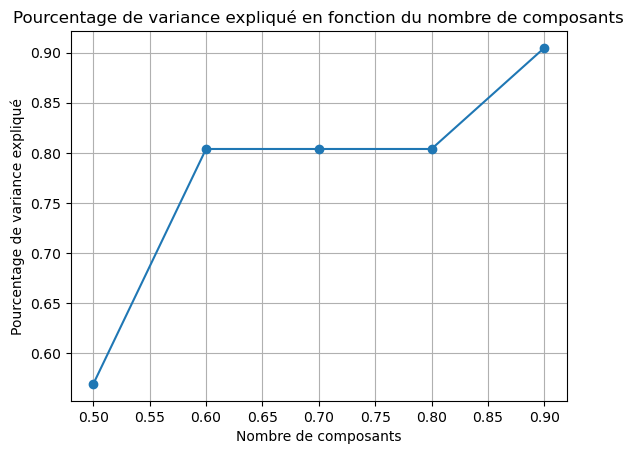

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Séparation des features (X) et de la cible (y) pour le DataFrame équilibré
X = df.drop('grav', axis=1)
y = df['grav']

# Définition des fractions de variance à conserver
n_components = np.arange(0.5, 1.0, 0.1)  # De 0.5 à 0.9 avec un pas de 0.1

# Initialisation pour stocker les résultats
explained_variance_ratios = []

# Boucle sur les différentes valeurs de n_components
for n in n_components:
    # Instanciation et ajustement de PCA avec la fraction de variance
    pca = PCA(n_components=n)
    pca.fit(X)

    # Stockage de la fraction de variance expliquée par les composants
    explained_variance_ratios.append(sum(pca.explained_variance_ratio_))

# Affichage du pourcentage de variance expliqué en fonction de n_components
plt.plot(n_components, explained_variance_ratios, marker='o')
plt.xlabel('Nombre de composants')
plt.ylabel('Pourcentage de variance expliqué')
plt.title('Pourcentage de variance expliqué en fonction du nombre de composants')
plt.grid(True)
plt.show()


<h1>Réduction de dimension + Entrainement du modèle + Calcul des métriques</h1>

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
import pandas as pd
import numpy as np

# Séparation des features (X) et de la cible (y) pour le DataFrame équilibré
X = df.drop('grav', axis=1)
y = df['grav']

# Définition des fractions de variance à conserver
n_components = np.arange(0.1, 1.0, 0.1)

# Initialisation pour stocker les résultats
results = []

# Initialisation des variables pour stocker les meilleures valeurs pour chaque métrique
best_accuracy = float('-inf')
best_geometric_mean = float('-inf')
best_balanced_accuracy = float('-inf')
best_accuracy_test = 0.0
best_accuracy_train = 0.0

# Boucle sur les différentes valeurs de n_components
for n in n_components:
    # Instanciation et ajustement de PCA avec la fraction de variance
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)

    # Division des données en ensembles d'apprentissage et de test
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Entrainement du modèle Random Forest
    from time import time
    t0 = time()
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    t1 = time() - t0
    print("Entrainement réalisé en {} secondes".format(round(t1,3)))

    # Prédiction sur l'ensemble de test
    t0 = time()
    y_pred = model.predict(X_test)
    t1 = time() - t0
    print("Prédiction réalisée en {} secondes".format(round(t1,3)))

    # Calcul de l'exactitude
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Pour n_components = {n}, l'exactitude est : {accuracy}")

    # Calcul du geometric mean score
    geometric_mean = geometric_mean_score(y_test, y_pred)
    print("Geometric Mean Score :", geometric_mean)

    # Calcul du balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy Score :", balanced_accuracy)

    # Calcul des scores sur l'ensemble de test et d'apprentissage
    score_test = model.score(X_test, y_test)
    score_train = model.score(X_train, y_train)

    # Détermination de la meilleure valeur pour chaque métrique
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components_accuracy = n
        best_accuracy_test = score_test
        best_accuracy_train = score_train

    if geometric_mean > best_geometric_mean:
        best_geometric_mean = geometric_mean
        best_n_components_geometric_mean = n

    if balanced_accuracy > best_balanced_accuracy:
        best_balanced_accuracy = balanced_accuracy
        best_n_components_balanced_accuracy = n

    # Stockage des métriques et du nombre de composants correspondant
    results.append((n, accuracy, geometric_mean, balanced_accuracy, score_test, score_train))
    print("\n")

# Choix de la meilleure valeur de n_components en fonction de chaque métrique
print("Meilleure valeur de n_components pour l'Accuracy :", best_n_components_accuracy)
print("Avec une Accuracy de :", best_accuracy)
print("Score sur l'ensemble de test :", best_accuracy_test)
print("Score sur l'ensemble d'apprentissage :", best_accuracy_train)

print("Meilleure valeur de n_components pour le Geometric Mean Score :", best_n_components_geometric_mean)
print("Avec un Geometric Mean Score de :", best_geometric_mean)

print("Meilleure valeur de n_components pour le Balanced Accuracy Score :", best_n_components_balanced_accuracy)
print("Avec un Balanced Accuracy Score de :", best_balanced_accuracy)


Entrainement réalisé en 138.986 secondes
Prédiction réalisée en 2.607 secondes
Pour n_components = 0.1, l'exactitude est : 0.26707122716685056
Geometric Mean Score : 0.26679868780307203
Balanced Accuracy Score : 0.2670307967294622


Entrainement réalisé en 141.855 secondes
Prédiction réalisée en 2.751 secondes
Pour n_components = 0.2, l'exactitude est : 0.26707122716685056
Geometric Mean Score : 0.26679868780307203
Balanced Accuracy Score : 0.2670307967294622


Entrainement réalisé en 138.59 secondes
Prédiction réalisée en 2.523 secondes
Pour n_components = 0.30000000000000004, l'exactitude est : 0.26707122716685056
Geometric Mean Score : 0.26679868780307203
Balanced Accuracy Score : 0.2670307967294622


Entrainement réalisé en 138.795 secondes
Prédiction réalisée en 2.563 secondes
Pour n_components = 0.4, l'exactitude est : 0.26707122716685056
Geometric Mean Score : 0.26679868780307203
Balanced Accuracy Score : 0.2670307967294622


Entrainement réalisé en 139.473 secondes
Prédiction r

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Utilisation du meilleur n_components pour PCA
best_n_components = best_n_components_accuracy

# Instanciation et ajustement de PCA avec la meilleure fraction de variance
pca = PCA(n_components=best_n_components)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Entrainement du modèle Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Évaluation de la performance en utilisant la validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_roc_auc_ovo = cross_val_score(model, X_pca, y, cv=cv, scoring='roc_auc_ovo', verbose=2, n_jobs=-1)

print(f"scores ROC AUC OvO pour chaque pli: {scores_roc_auc_ovo}")
print(f"Moyenne des scores ROC AUC OvO : {scores_roc_auc_ovo.mean()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished


scores ROC AUC OvO pour chaque pli: [0.61956317 0.61836001 0.62015501 0.61994562 0.61815522]
Moyenne des scores ROC AUC OvO : 0.6192358059402215
